# Data Visualiser for Data-Driven Water Temperature Prediction 

- Analysing the dataset created by run_example.sh visually

In [1]:
import pandas as pd 
import datetime
import numpy as np
import copy

import matplotlib.pyplot as plt

import matplotlib.dates as mdates
mydates = mdates.DateFormatter('%m-%d')

## Reading and Preprocessing data set 

In [2]:
# Read the example data
data = pd.read_csv("havvarsel-data-driven-pred-data/dataset_4.csv")

In [3]:
# Listing the variables contained in the data set
"""
water_temp is the measured temperature

norkyst_water_tempD is the forecasted water temperature for depth D (0 is surface)

the other values come from the classical weather forecast
"""

list(data.keys())

['time',
 'water_temp',
 'norkyst_water_temp0',
 'norkyst_water_temp3',
 'norkyst_water_temp10',
 'air_temperature_2m',
 'wind_speed_10m',
 'wind_direction_10m',
 'precipitation_amount',
 'cloud_area_fraction',
 'integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time']

In [4]:
# The dataset will later on be cleaned and it is helpful to keep some temporal information
data["time"] = pd.to_datetime(data["time"])
data = data.set_index("time")

years = list(dict.fromkeys(list(data.index.year)))
years

[2019, 2020, 2021, 2022]

In [5]:
# NOTE: Some columns contain only integer values

# Casting to all entries to floats
for column in data.columns:
    if data[column].dtype != "float64":
        data[column] = data[column].astype(float)

In [6]:
## After the preliminary data-conversion, we save a copy of the original data before do further cleaning, modifying, etc 
original_data = copy.deepcopy(data)

In [7]:
# NOTE: Some of the libraries require special attention if the data contains NaNs
clean_nan = False

if clean_nan:
    data = data.dropna()

## Data Exploration

Functionalities for the plotting of time series 

In [8]:
def plot_timeseries_all_years(param):
    """Plotting timeseries of the param column 
    for all years in the data set 
    over the same date in year x-axis"""
    fig, ax = plt.subplots(figsize=(42,6))
    for year in years:
        print(year)
        start_time = datetime.datetime.strptime(str(year)+"-01-01T00:00 +0000", "%Y-%m-%dT%H:%M %z")
        end_time = datetime.datetime.strptime(str(year)+"-12-31T23:59 +0000", "%Y-%m-%dT%H:%M %z")
        ax.plot(data[data.index.year==year][param].dropna().index+pd.offsets.DateOffset(year=2000),
            data[data.index.year==year][param].dropna(), 
            marker=".", linestyle="")

    ax.xaxis.set_major_formatter(mydates)
    plt.legend(years)
    plt.xlabel("date [MM-DD]")
    plt.ylabel(param)
    plt.title("Time series")


2019
2020


/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


2021
2022


/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


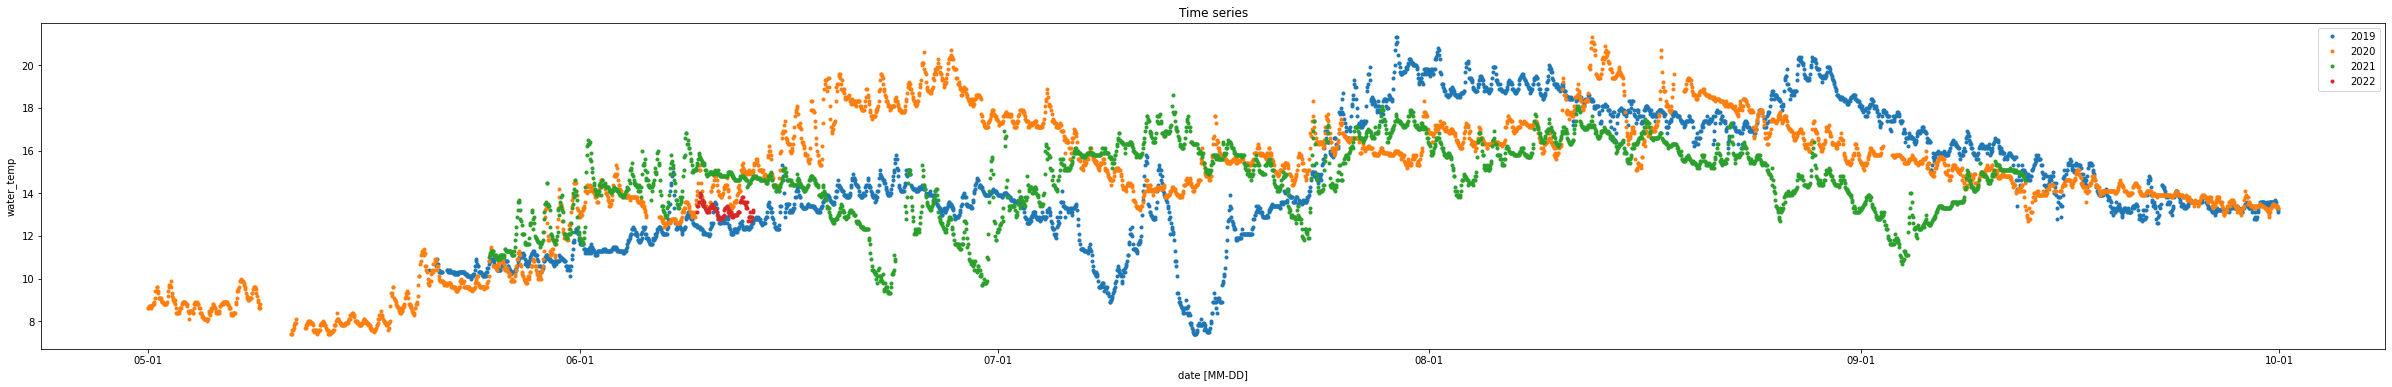

In [9]:
plot_timeseries_all_years("water_temp")

Evaluation of NorKyst

Taking the year 2020 and comparing the NorKyst forecast with the measures temperatures 

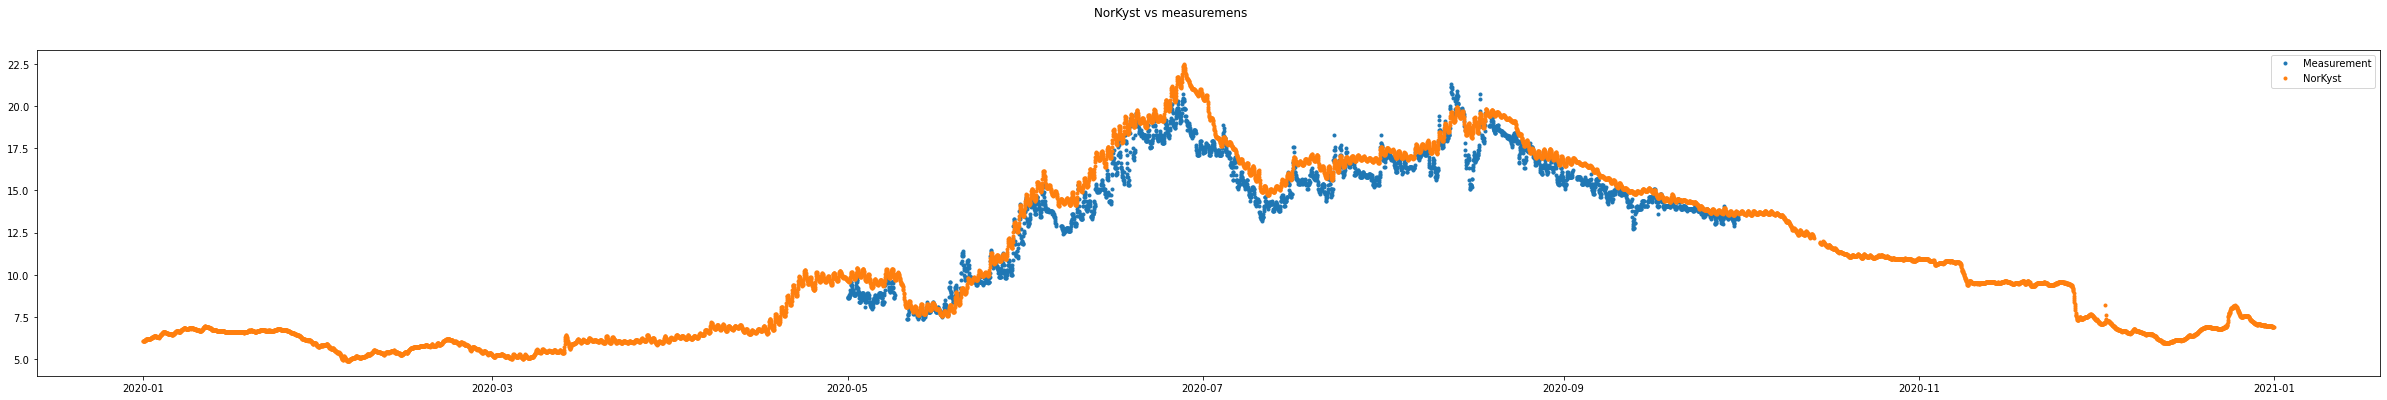

In [10]:
def plot_timeseries_vs_norkyst(year, summer=False):
    # NOTE: Often measurement are only available in summer and hence we directly look at summer only
    # TODO: Do the same for winter, if measurements are available
    fig, ax = plt.subplots(1,1,figsize=(42,6))
    fig.suptitle("NorKyst vs measuremens")
    if summer:
        ax.plot(original_data[str(year)+"-06-01":str(year)+"-10-01"]["water_temp"].dropna().index, original_data[str(year)+"-06-01":str(year)+"-10-01"]["water_temp"].dropna(), marker=".", ls="")
        ax.plot(original_data[str(year)+"-06-01":str(year)+"-10-01"]["norkyst_water_temp0"].dropna().index, original_data[str(year)+"-06-01":str(year)+"-10-01"]["norkyst_water_temp0"].dropna(), marker=".", ls="")
    else:
        ax.plot(original_data[str(year)+"-01-01":str(year)+"-12-31"]["water_temp"].dropna().index, original_data[str(year)+"-01-01":str(year)+"-12-31"]["water_temp"].dropna(), marker=".", ls="")
        ax.plot(original_data[str(year)+"-01-01":str(year)+"-12-31"]["norkyst_water_temp0"].dropna().index, original_data[str(year)+"-01-01":str(year)+"-12-31"]["norkyst_water_temp0"].dropna(), marker=".", ls="")

    plt.legend(["Measurement", "NorKyst"])
    return fig, ax

fig, ax = plot_timeseries_vs_norkyst(2020)

Text(0.5, 1.0, 'Grey: big mismatch, Green: good calibration')

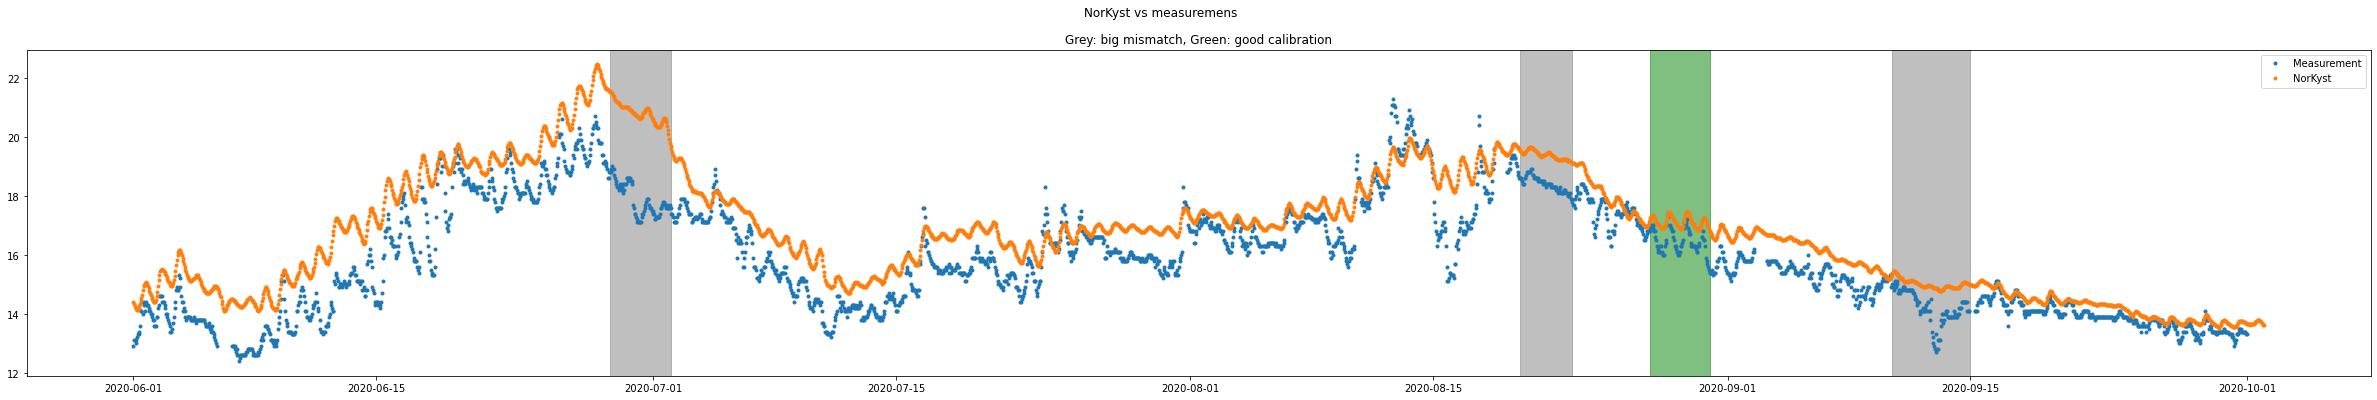

In [11]:
fig, ax = plot_timeseries_vs_norkyst(2020, summer=True)

def add_shade(ax, start, end, color):
    ax.axvspan(start, end, alpha=0.5, color=color)

# One can choose times that 
add_shade(ax,"2020-06-28 12:00", "2020-07-02", color='grey')
add_shade(ax,"2020-08-20", "2020-08-23", color='grey')
add_shade(ax,"2020-09-10 12:00", "2020-09-15", color='grey')
add_shade(ax,"2020-08-27 12:00", "2020-08-31", color='green')

ax.set_title("Grey: big mismatch, Green: good calibration")

In [12]:
def plot_timeseries_period(start, end):
    """Plotting timeseries of all param in data 
    for some period between start and end"""
    params = data.columns
    legend = list(params)
    
    fig, axs = plt.subplots(3,figsize=(42,16))
    
    axs[0].plot(data[start:end]["water_temp"].dropna().index, data[start:end]["water_temp"].dropna(), 
                marker=".", ms=15, lw=3.5)

    axs[0].plot(data[start:end]["norkyst_water_temp0"].dropna().index, data[start:end]["norkyst_water_temp0"].dropna(), 
                marker=".", ms=15, lw=3.5)

    axs[0].plot(data[start:end]["norkyst_water_temp3"].dropna().index, data[start:end]["norkyst_water_temp3"].dropna(), 
                marker=".", ms=10, lw=1)

    axs[0].plot(data[start:end]["norkyst_water_temp10"].dropna().index, data[start:end]["norkyst_water_temp10"].dropna(), 
                marker=".", ms=10, lw=1)

    axs[0].legend(["water_temp [degC]", "norkyst_water_temp0 [degC]", "norkyst_water_temp3 [degC]", "norkyst_water_temp10 [degC]"])




    axs[1].plot(data[start:end]["air_temperature_2m"].dropna().index, data[start:end]["air_temperature_2m"].dropna() -273.15, 
                marker=".", ms=10, lw=1)
    
    axs[1].plot(data[start:end]["wind_speed_10m"].dropna().index, data[start:end]["wind_speed_10m"].dropna(), 
                marker=".", ms=10, lw=1)

    axs[1].set_ylim(-2,28)
    
    direction_dates = mdates.date2num(data[start:end]["wind_direction_10m"].dropna().index)
    direction_values = data[start:end]["wind_direction_10m"].dropna()/360*2*np.pi

    # Since the dates on the x axis have a different scaling than the values on the y axis,
    # we have to correct the x-coordinate of the arrow end point such that the arrows also visually are on a unit circle
    # Therefore, we calculate what the reference length of a unit vector on the y axis (roughly divided by 3, since there are 3 subplots) is 
    # and scale the unit length on the x axis with this
    vis_correct = (fig.get_size_inches()[0]/(direction_dates[-1] - direction_dates[0]))/(fig.get_size_inches()[1]/(30)/3)    

    arrow_stretch = 2
    
    # Plotting arrows only for every second data point to keep plot cleaner
    for d in range(0,len(direction_dates),2):
        axs[1].annotate("", xy=(direction_dates[d]+arrow_stretch*np.sin(direction_values[d])/vis_correct, arrow_stretch*np.cos(direction_values[d])), xytext=(direction_dates[d], 0.0),
            arrowprops={"width":0.1, "headwidth":5, "headlength":5})
        #axs[1].arrow(direction_dates[d], 0, np.sin(direction_values[d])/vis_correct, np.cos(direction_values[d]), head_width=0.025, head_length=0.5)

    axs[1].legend(["air_temperature_2m [degC]", "wind_speed_10m [m/s]", "wind_direction_10m"])




    axs[2].plot(data[start:end]["cloud_area_fraction"].dropna().index, data[start:end]["cloud_area_fraction"].dropna()/10, 
                marker=".", ms=10, lw=1)

    axs[2].plot(data[start:end]["integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time"].dropna().index, data[start:end]["integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time"].dropna()/1e5, 
                marker=".", ms=10, lw=1)

    axs[2].plot(data[start:end]["precipitation_amount"].dropna().index, data[start:end]["precipitation_amount"].dropna(), 
                marker=".", ms=10, lw=1)


    axs[2].legend(["cloud_area_fraction [10%]", "sun_intensity [1e5 W/m^2]", "precipitation_amount [mm]"])
                
    axs[2].set_xlabel("date [MM-DD HH]")
    fig.suptitle("Time series")

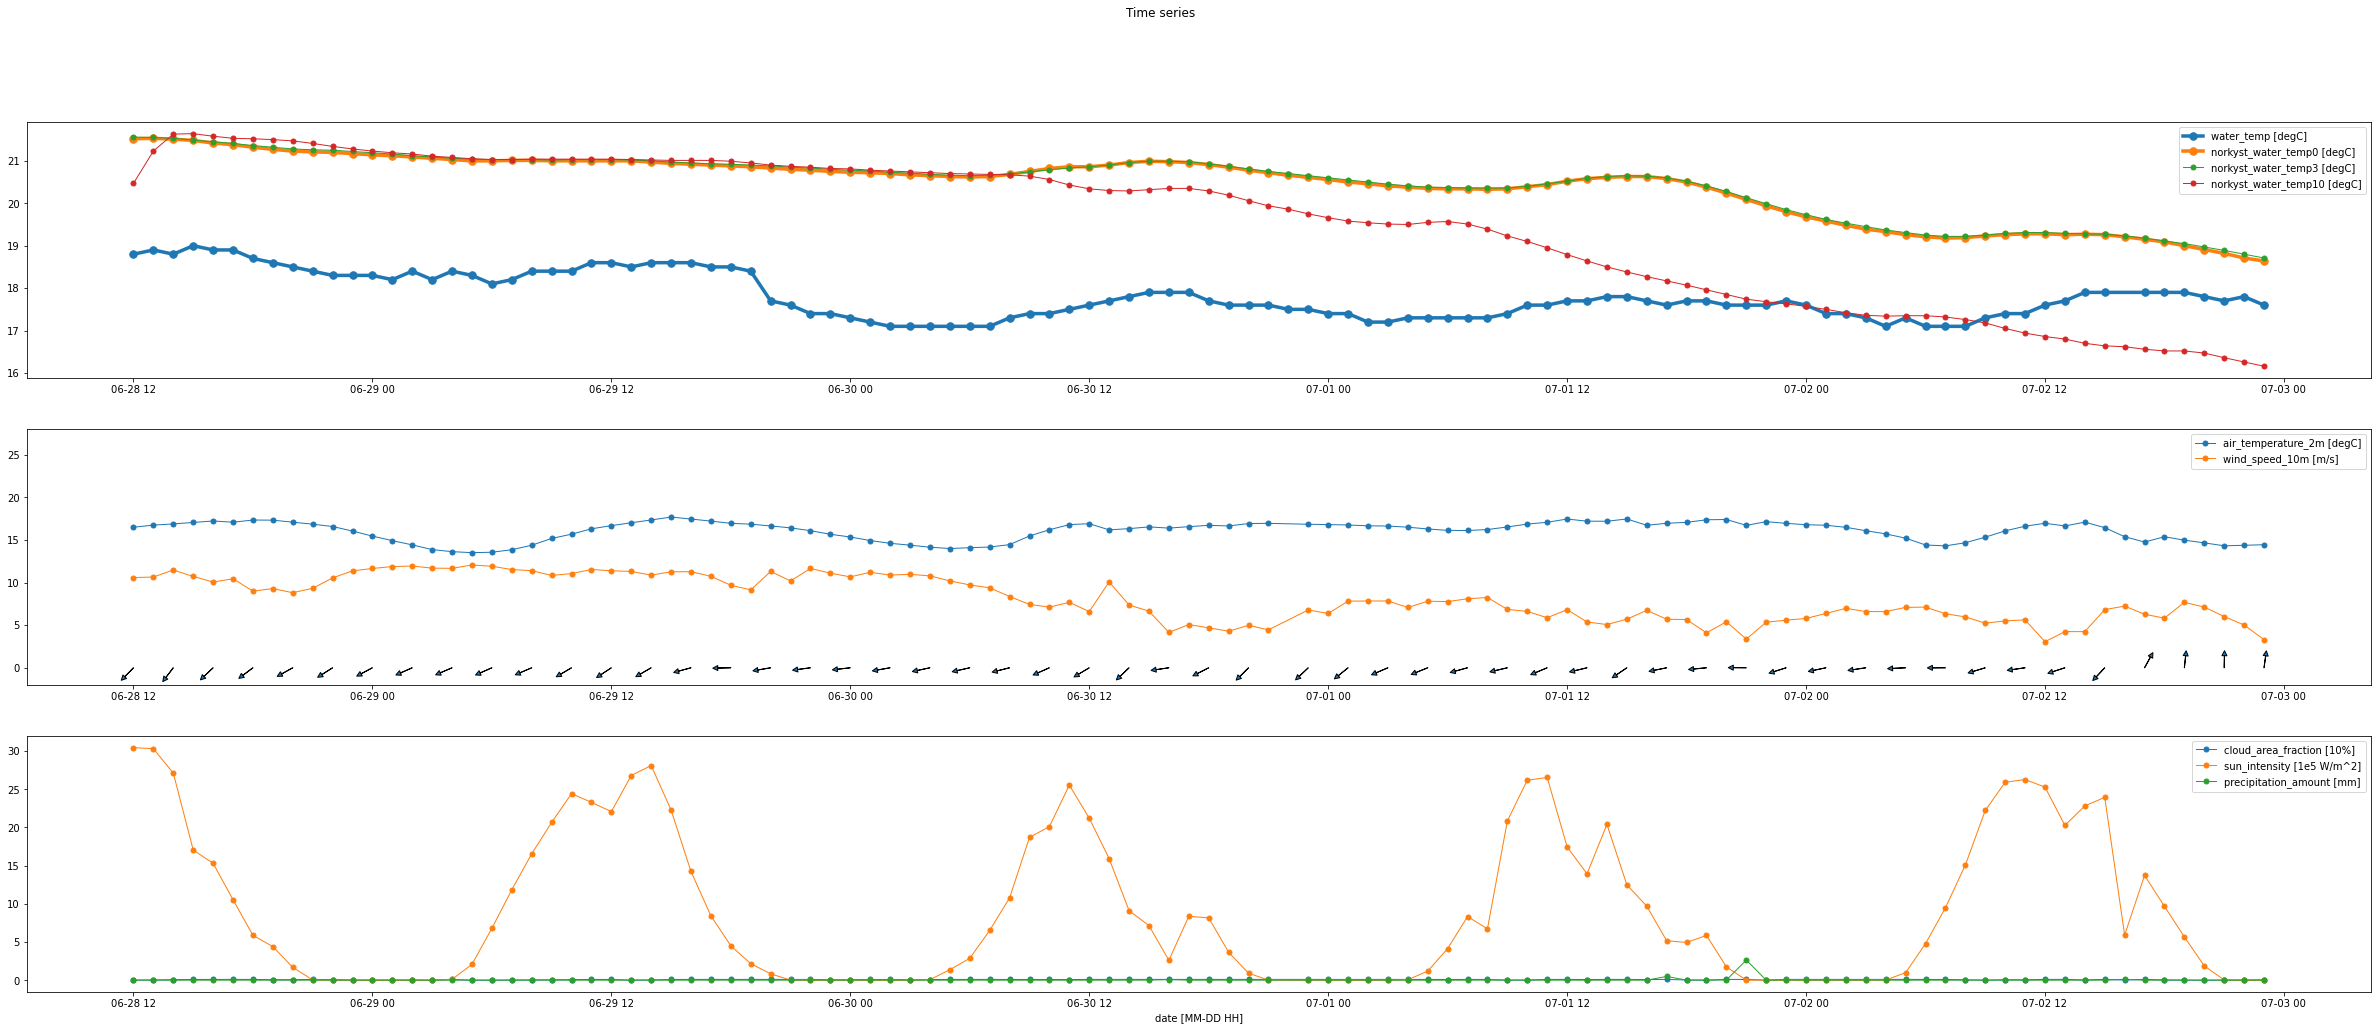

In [13]:
plot_timeseries_period("2020-06-28 12:00","2020-07-02")

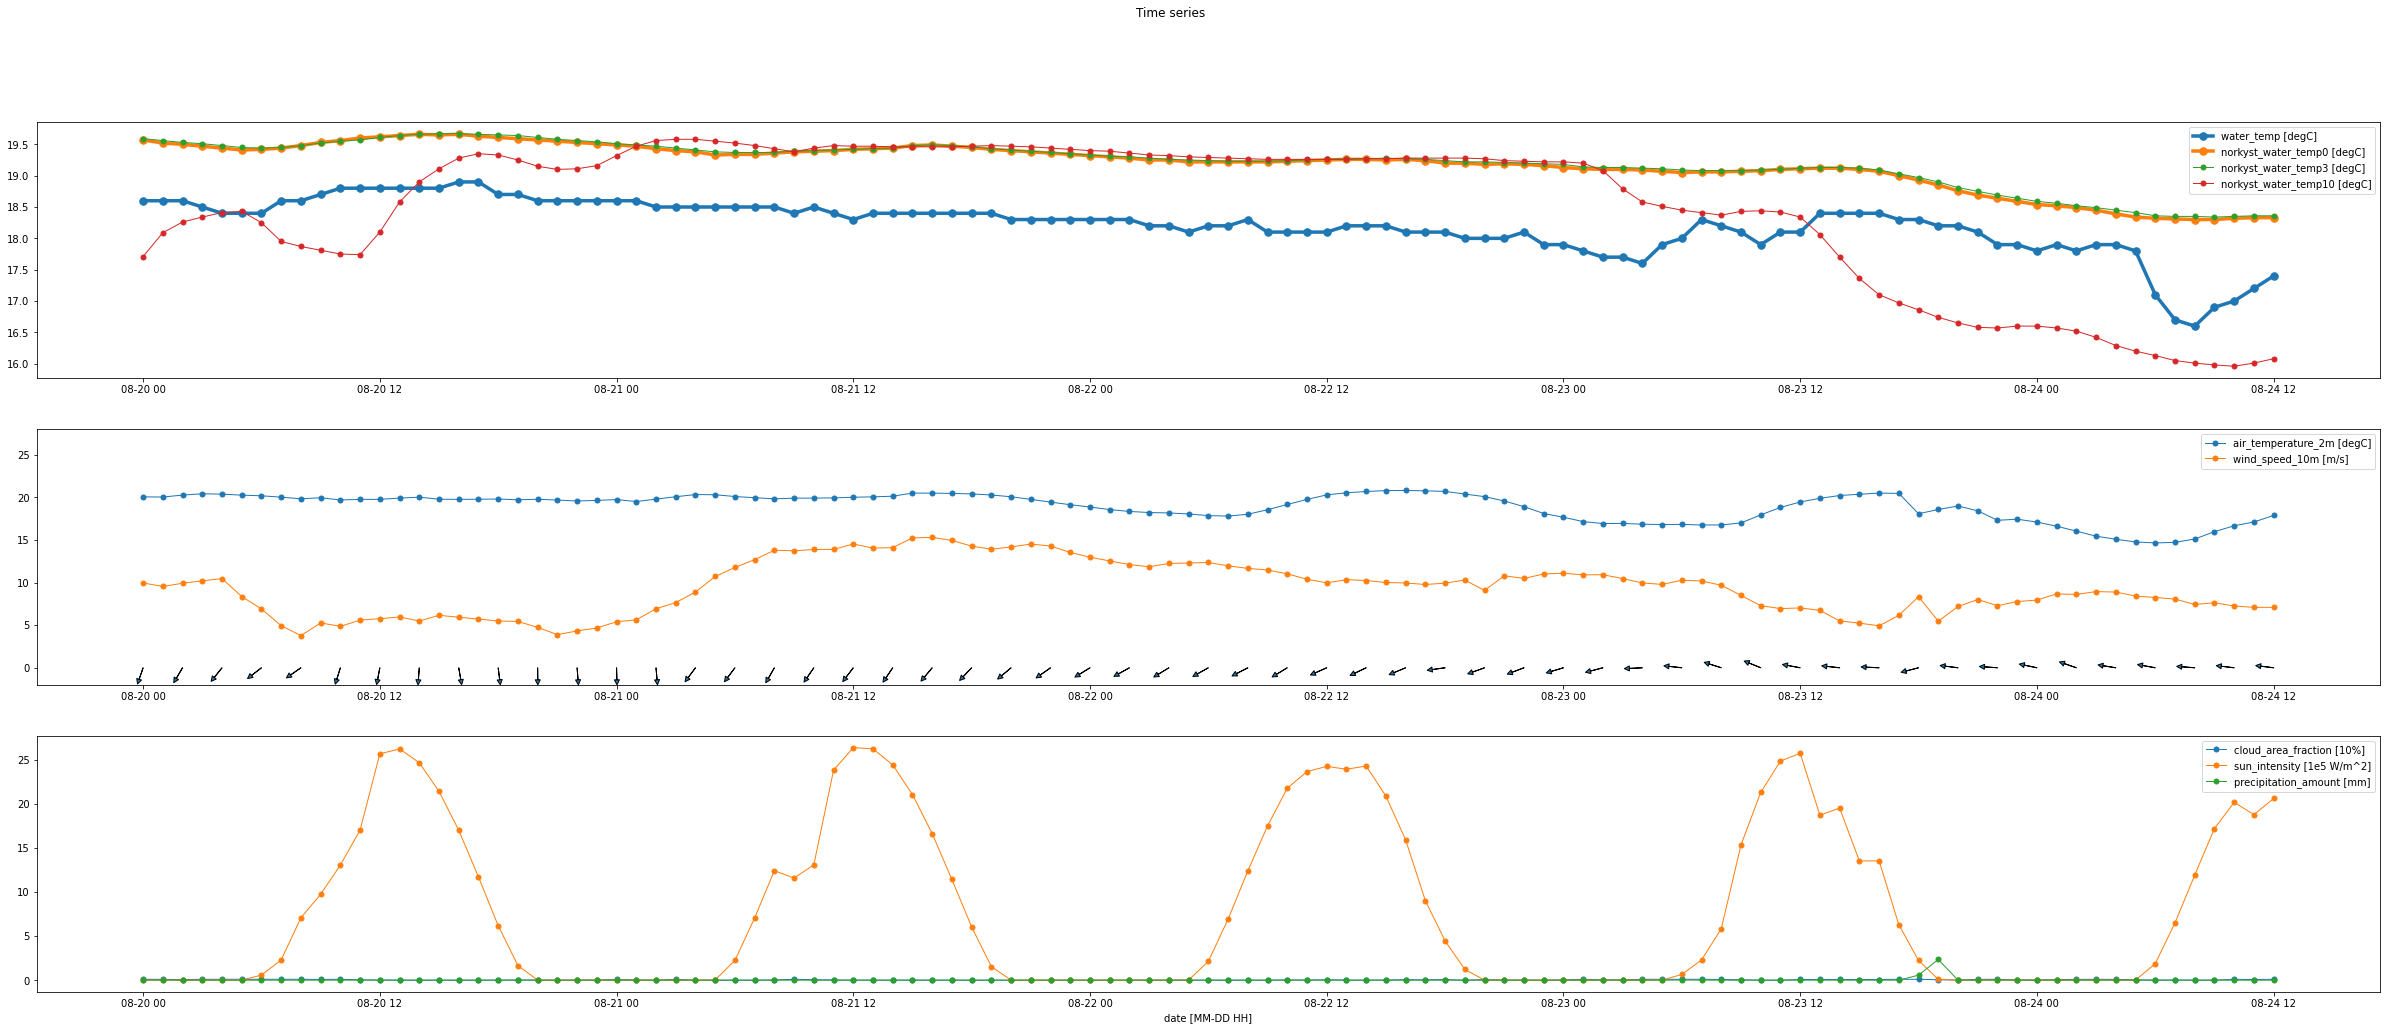

In [14]:
plot_timeseries_period("2020-08-20", "2020-08-24 12:00")

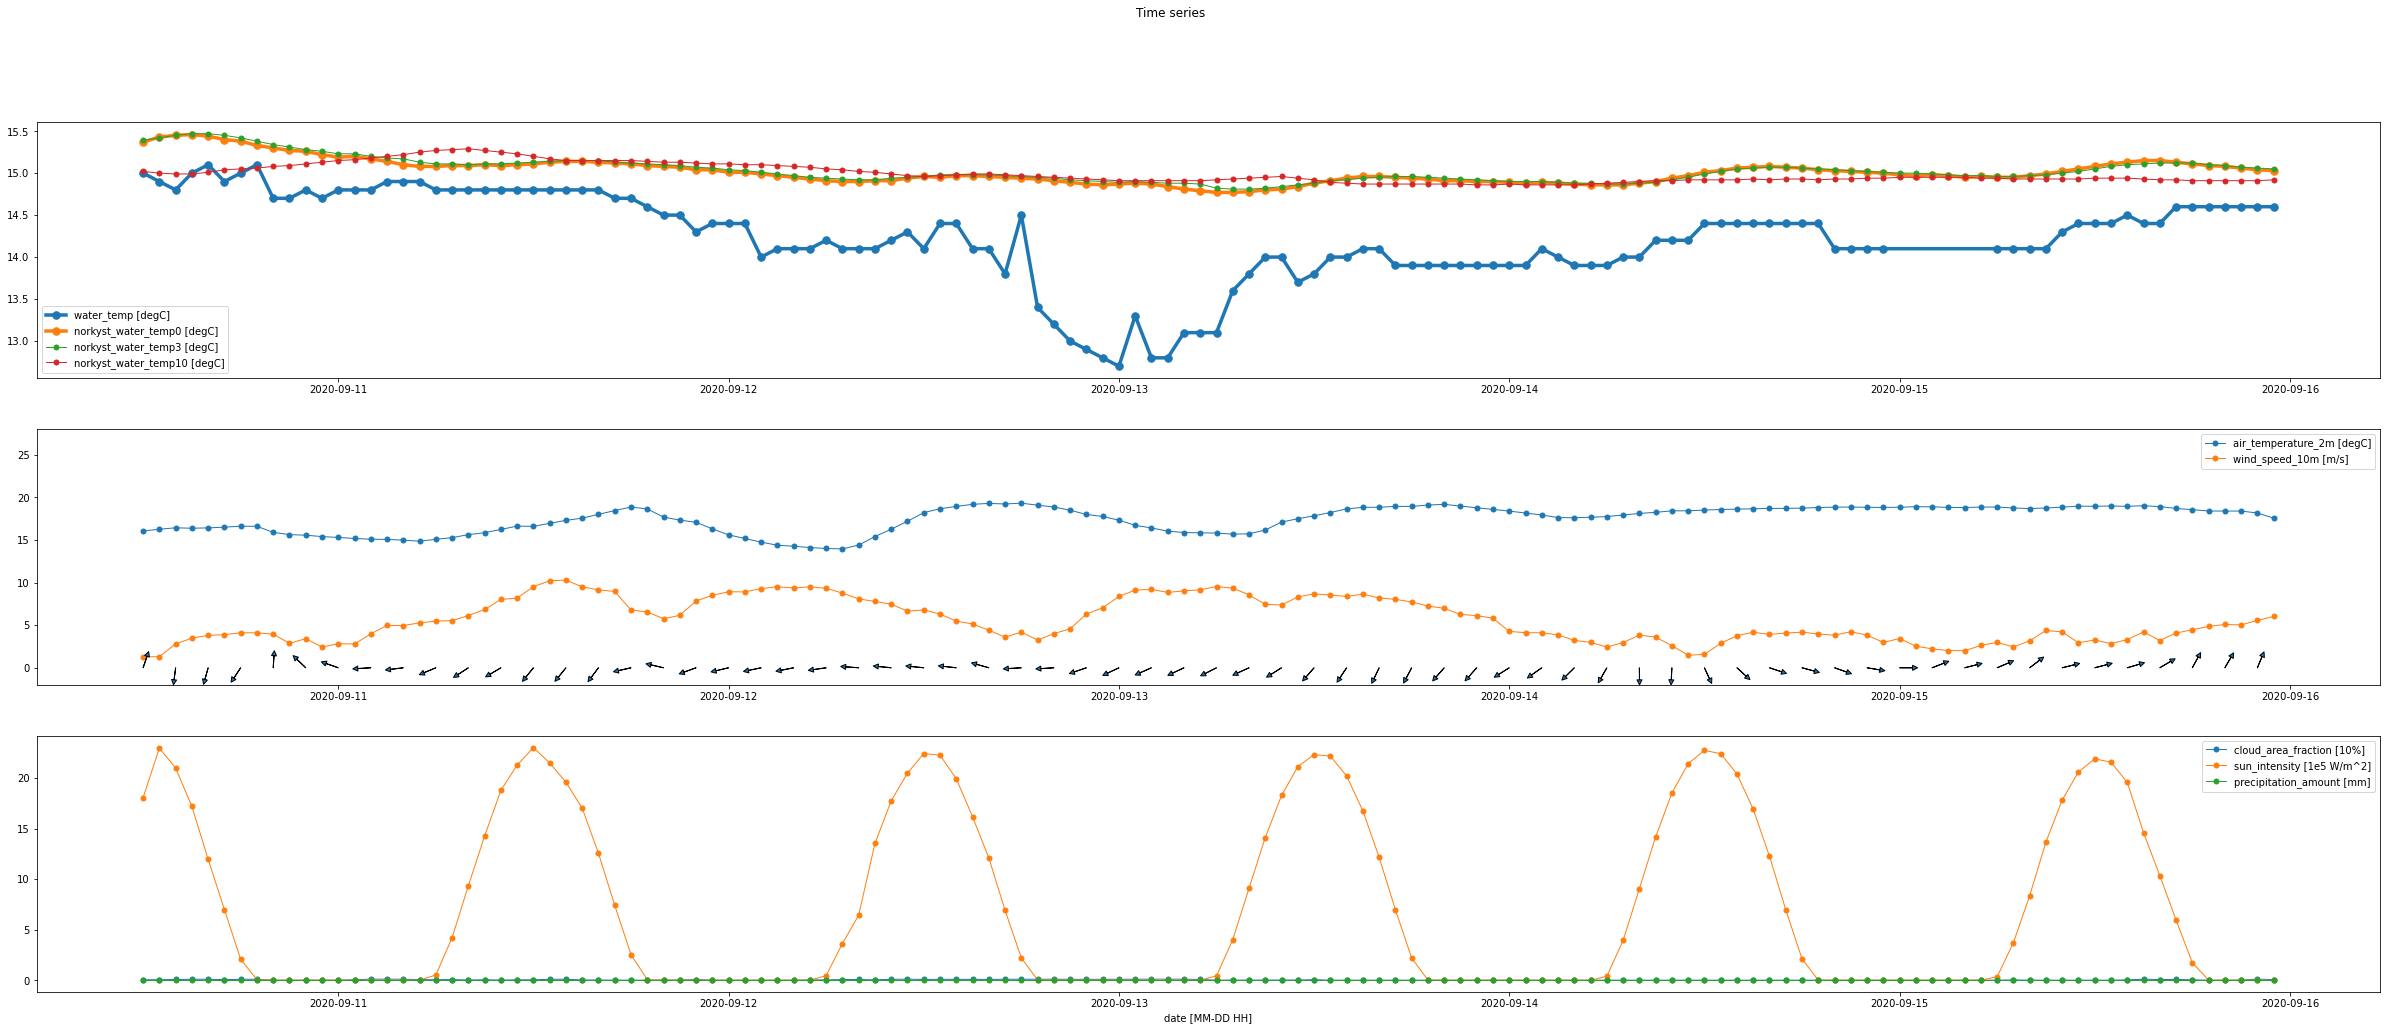

In [15]:
plot_timeseries_period("2020-09-10 12:00", "2020-09-15")

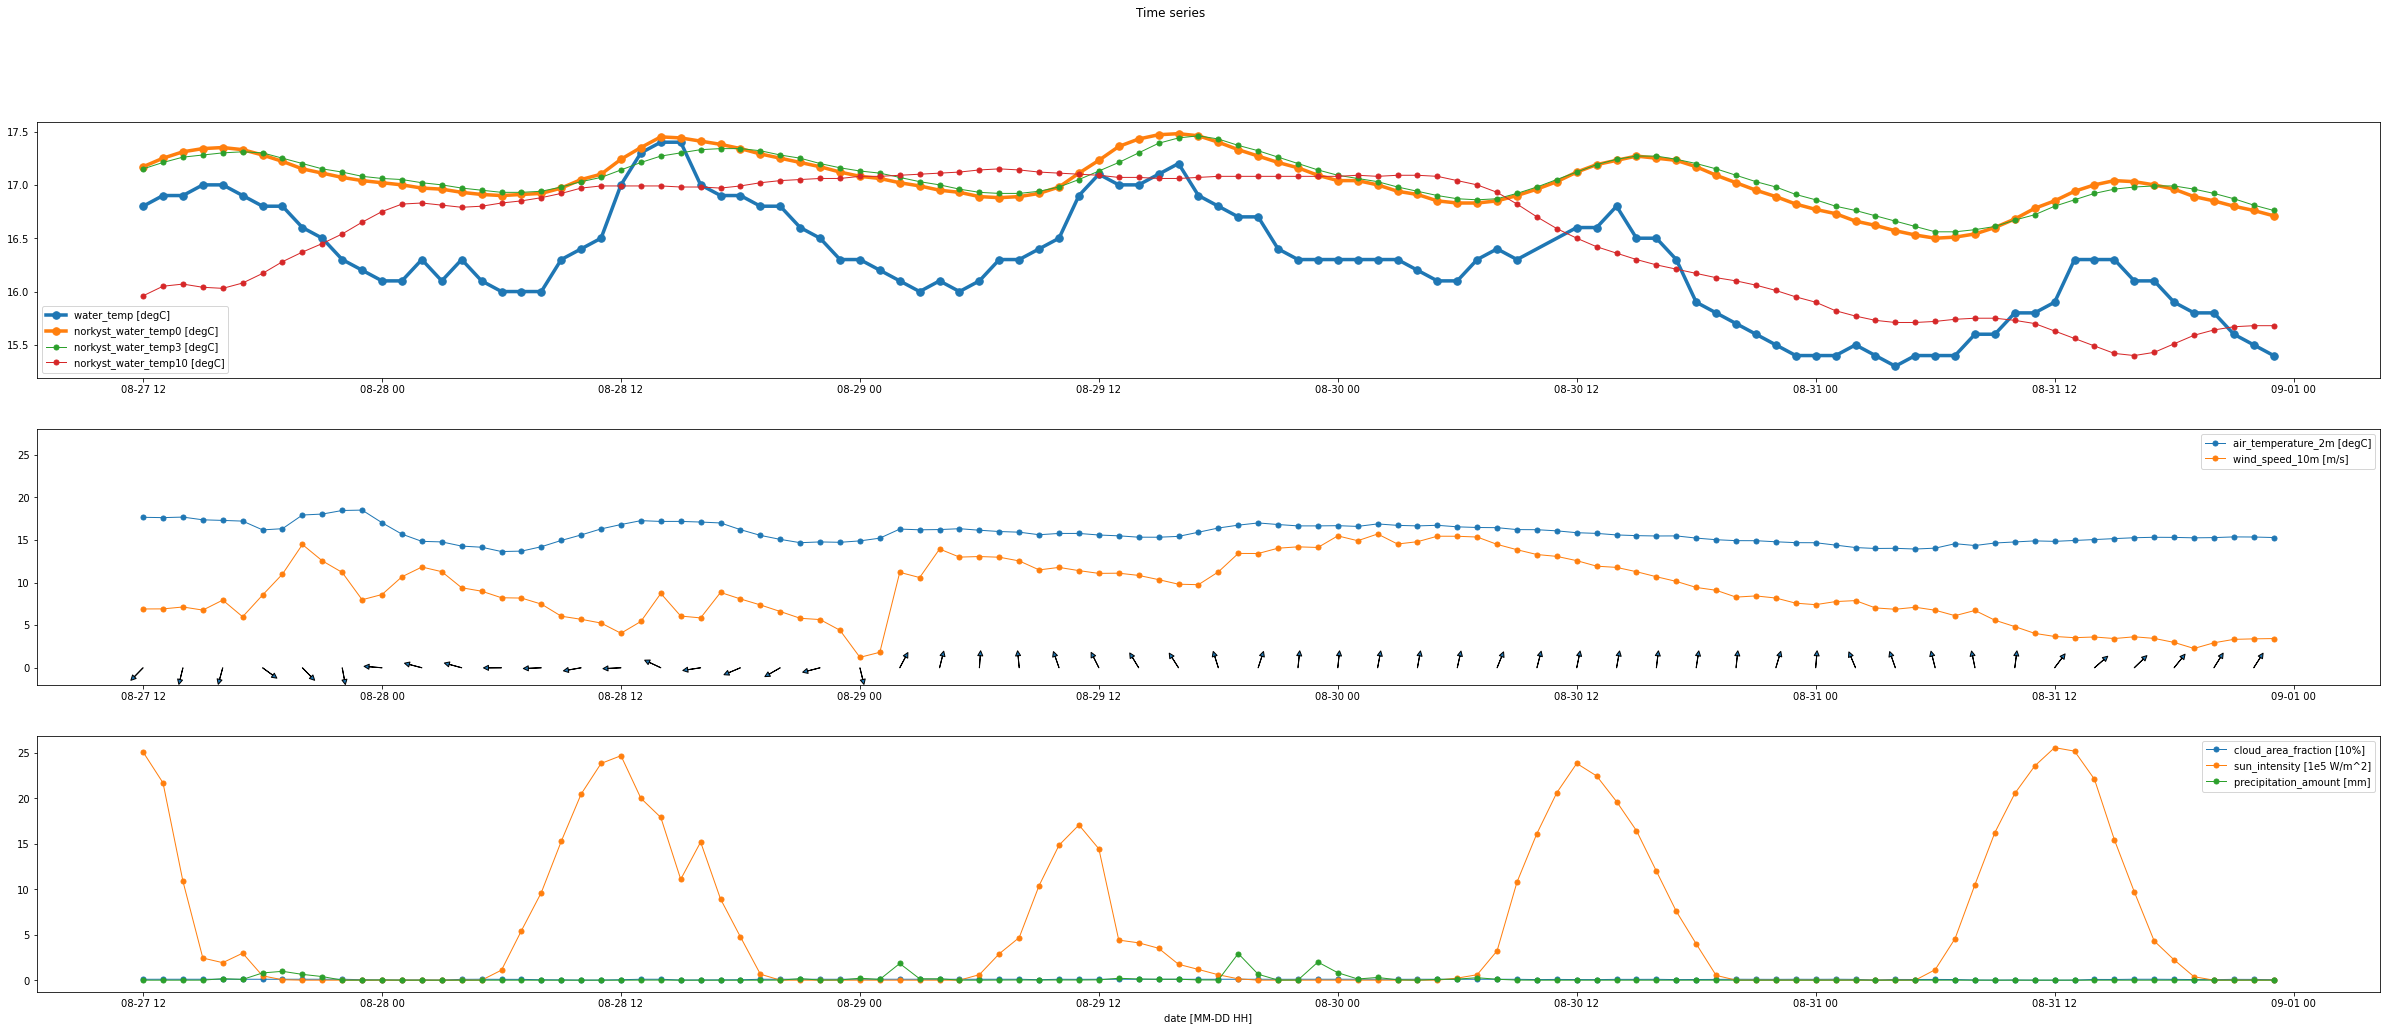

In [16]:
plot_timeseries_period("2020-08-27 12:00", "2020-08-31")